# Ajuste de modelo HSMM para datos glucemicos y predicción de hiploglucemia

## Uso del algoritmo Expectation-Maximization para estimar parametros de un HSMM

En este notebook se hara uso sel paquete ``mhsmm`` para usar el algoritmo de Expectation-Maximization para ajustar los parámetros de un modelo de semi-Markov para datos de glucosa provenientes de CGM con el objetivo de predecir eventos de hipoglucemia.

Para predecir la secuencia de estados más probable que ha pasado se hara uso de la función ``predict`` del mismo paquete que implementa el algoritmo de Viterbi.

Este notebook hace uso de ``RCall`` dado que el paquete ``mhsmm`` es del lenguaje ``R`` y usar ``RCall`` en vez del kernel de ``R`` permite que el notebook pueda ser compartido via ``Colab``.

### Instalación de librerías necesarias (Python)

In [1]:
!pip install rpy2
import rpy2.robjects as robjects
robjects.r('install.packages("RCall")')
!pip install ipython
%load_ext rpy2.ipython

(as ‘lib’ is unspecified)



### Instalación de librerías necesarias (R)

In [2]:
%%R
install.packages('RCall')
install.packages("mhsmm")
library(mhsmm)

(as ‘lib’ is unspecified)

(as ‘lib’ is unspecified)







	‘/tmp/RtmplAi3sq/downloaded_packages’




### Predicción con datos simulados

Usados los datos generados en el notebook ``Data_Preprocessing.ipynb``, se va a probar el uso del algoritmo Expectation-Maximization y el algoritmo de Viterbi. Sin embargo los datos simulados no son idoneos para hacer la predicción pues tienen comportamientos ficticios y muy por encima del valor de hipoglucemia.

#### Importación de los datos simulados

In [3]:
%%R
data<-read.csv("simulated_data_1_patient.csv")

In [4]:
%%R
head(data)

  id                time       gl gl_noise state
1  1 2020-12-12 05:07:04 77.02375 76.71813     1
2  1 2020-12-12 05:12:04 64.44068 63.17814     1
3  1 2020-12-12 05:17:04 94.42932 95.20803     1
4  1 2020-12-12 05:22:04 83.92058 83.59153     1
5  1 2020-12-12 05:27:04 77.92287 78.32017     1
6  1 2020-12-12 05:32:04 69.38765 67.53526     1


El paquete ``mhsmm`` permite al usuario poner su propia función de densidad de emisión y ajustar el proceso en el paso de Maximización. Para eso se usaron las siguientes función que fueron usadas en el trabajo de referencia.

In [5]:
%%R
####################################################
## Función para re-estimar los parámetros de la    ##
## Distribución Gamma de la Distribución de Emisión ##
####################################################

mstep.gamma <- function(x, wt = NULL){
  # Aplica la función weighted.params a cada columna de wt para obtener los parámetros
  tmp <- apply(wt, 2, function(w) weighted.params(x, w))

  # Devuelve una lista con los parámetros 'shape' y 'scale' para la distribución Gamma
  return(list(shape = tmp[1, ], scale = tmp[2, ]))
}

# Función auxiliar para calcular los parámetros 'shape' y 'scale' ponderados
weighted.params <- function(x, wt){
  # Calcula la media ponderada de 'x' usando 'wt', ignorando valores NA
  tmp1 <- weighted.mean(x, wt, na.rm = TRUE)

  sum <- 0
  # Bucle que recorre los valores de 'x' y 'wt'
  for(i in 1:length(x)){
    # Acumula la suma ponderada de las diferencias al cuadrado entre los valores y la media
    sum <- sum + wt[i] * (ifelse(is.na(x[i]), tmp1, x[i]) - tmp1) ^ 2
  }

  # Filtra los pesos no nulos (cuando no hay NA en 'x')
  wt_notNulls <- wt[!(1:length(wt)) %in% which(is.na(x))]

  # Calcula la varianza ponderada
  tmp2 <- sum / sum(wt_notNulls)

  # Calcula el parámetro 'scale' de la distribución Gamma
  scale <- tmp2 / tmp1

  # Calcula el parámetro 'shape' de la distribución Gamma
  shape <- tmp1 / scale

  # Devuelve los parámetros 'shape' y 'scale'
  return(c(shape, scale))
}


###############################################
## Función para generar 1 valor aleatorio de  ##
## una Distribución Gamma para el Estado j    ##
###############################################

rgamma.hsmm <- function(j, model){
  # Genera un valor aleatorio de una distribución Gamma para el estado 'j'
  rgamma(n = 1, shape = model$parms.emission$shape[j], scale = model$parms.emission$scale[j])
}


######################################################
## Función para generar los valores de densidad de  ##
## una Distribución Gamma para un vector de cuantiles ##
## en el Estado j                                    ##
######################################################

dgamma.hsmm <- function(x, j, model){
  # Calcula los valores de densidad de la distribución Gamma para el estado 'j'
  ret <- dgamma(x = x, shape = model$parms.emission$shape[j], scale = model$parms.emission$scale[j])

  # Reemplaza los valores NA con 1 (similar a lo que hace el paquete mhsmm)
  ret[is.na(ret)] <- 1

  # Devuelve los valores de densidad
  ret
}


### Creación del modelo HSMM

A continuación se hace un ajuste del modelo a los datos simulados, se usan como parametros iniciales aquellos que se obtuvieron en el trabajo de referencia.

In [6]:
%%R
J <- 5

p.init <- c(0.15, 0.225, 0.25, 0.225, 0.15)

trans_matrix <- matrix(c(
  0, 1, 0, 0, 0,
  0.467, 0, 0.533, 0, 0,
  0, 0.546, 0, 0.454, 0,
  0, 0, 0.613, 0, 0.387,
  0, 0, 0, 1, 0
), nrow = 5, byrow = TRUE)


dist_sojourn <- matrix(c(0.7579934, 33.82615,
                        0.9932942, 11.95013,
                        1.1291341, 10.97301,
                        1.2104759, 12.60661,
                        1.1880755, 32.62419 ), nrow = 5, ncol = 2, byrow = TRUE)

dist_emission <- matrix(c(42.15187, 2.039293,
                        110.10547, 1.107393,
                        131.68450, 1.239174,
                        151.21247, 1.419063,
                        51.91903, 5.666516 ),nrow = 5, ncol = 2, byrow = TRUE)

emission_dist <- list(shape = dist_emission[, 1], scale = dist_emission[, 2])

sojourn_dist <- list(shape = dist_sojourn[, 1], scale = dist_sojourn[, 2], type = "gamma")


model <- hsmmspec(init = p.init, trans = trans_matrix, parms.emission = emission_dist, sojourn = sojourn_dist, dens.emission = dgamma.hsmm, rand.emission = rgamma.hsmm, mstep = mstep.gamma)


#### Selección de datos observados

Se tomaron 2016 registros como datos observados, que son lo equivalente a 7 días.

In [7]:
%%R
observed_CGM_list<- data[1:2016,]$gl
states_observed<- data[1:2016,]$state
length(observed_CGM_list)

[1] 2016


### Entrenamiento del modelo con el algoritmo EM

A continuación se ajustan los parametros del modelo a los datos simulados. Se puede ver que hay una muy rápida convergencia del algoritmo EM, lo cual sobresale mucho con la implementación del ajuste de parametros realizada a base de MCMC.

In [8]:
%%R
M <- 144
train <- list(x = observed_CGM_list, N = 2016)
h.activity <- hsmmfit(train, model, mstep = mstep.gamma, maxit = 10000000, M = M, lock.transition = FALSE, lock.d = FALSE, graphical = FALSE)

Ahora miremos los datos en ese lapso de tiempo

In [9]:
%%R
head(states_observed)

[1] 1 1 1 1 1 1


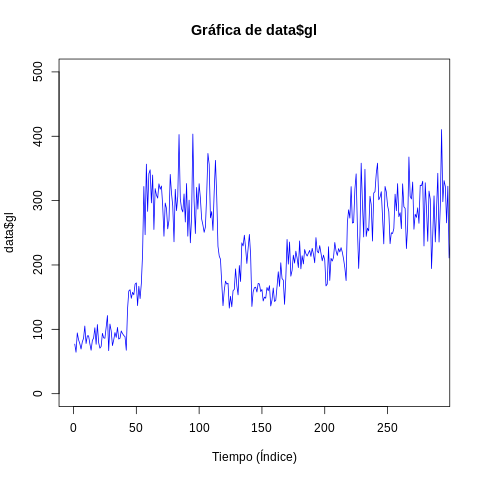

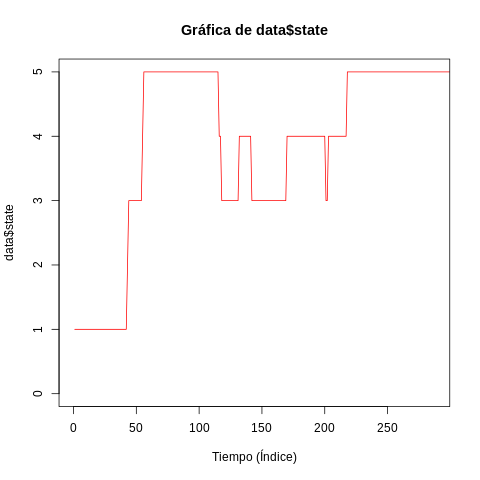

In [10]:
%%R
plot(observed_CGM_list, type = "l", main = "Gráfica de data$gl", xlab = "Tiempo (Índice)", ylab = "data$gl", col = "blue", xlim=c(0,288), ylim=c(0,500))

plot(states_observed, type = "l", main = "Gráfica de data$state", xlab = "Tiempo (Índice)", ylab = "data$state", col = "red", xlim=c(0,288), ylim=c(0,5))

Y ahora veamos la verosimilitud del ajuste de parametros, donde podemos ver que en efecto convergió

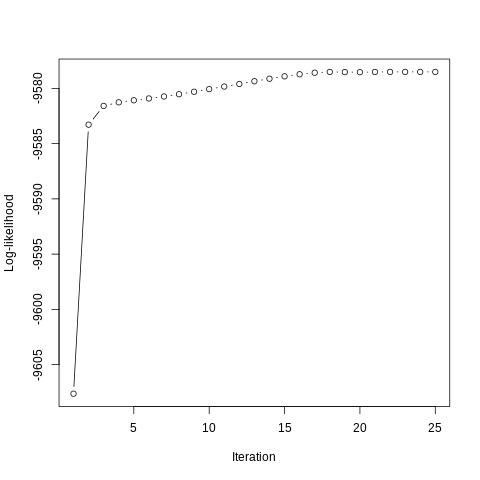

In [11]:
%%R
plot(h.activity$loglik,type='b',ylab='Log-likelihood',xlab='Iteration')

### Resumen del modelo

In [12]:
%%R
summary(h.activity)


Starting distribution = 
[1] 1.0e+00 0.0e+00 0.0e+00 1.9e-15 2.1e-15

Transition matrix = 
     [,1] [,2] [,3] [,4] [,5]
[1,]    0 1.00 0.00 0.00 0.00
[2,]    0 0.00 1.00 0.00 0.00
[3,]    0 0.11 0.00 0.89 0.00
[4,]    0 0.00 0.65 0.00 0.35
[5,]    0 0.00 0.00 1.00 0.00

Sojourn distribution parameters = 
$shape
[1] 6523.3482862    1.2512269    1.6310633    1.4590212    0.8656999

$scale
[1]  0.006282584  8.371042480  7.487138738  9.802979758 52.276513105

$type
[1] "gamma"


Emission distribution parameters = 
$shape
[1]  46.47455  87.23145 131.42082 153.78348  49.56295

$scale
[1] 1.863723 1.382556 1.235575 1.404227 5.937218



### Uso del Algoritmo de Viterbi

Ahora podemos usar la función predict que implementa el Algoritmo de Viterbi para modelos oculto de semi-Markov

In [13]:
%%R
predicted <- predict(h.activity,train)

Podemos comparar los estados reales con los simulados:

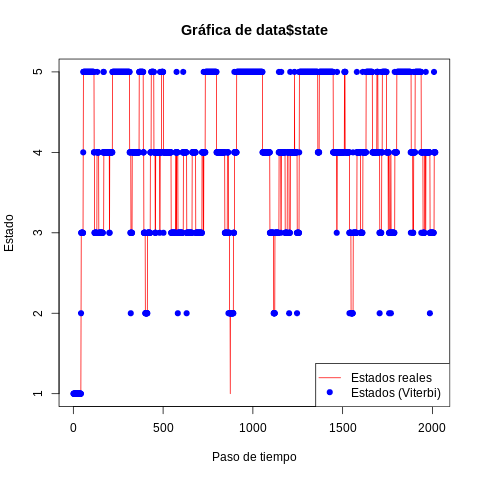

In [14]:
%%R
plot(data[1:2016,]$state, type = "l", main = "Gráfica de data$state",
     xlab = "Paso de tiempo", ylab = "Estado", col = "red")


points(predicted$s[1:2016], col = "blue", pch = 19)

legend("bottomright", legend = c("Estados reales", "Estados (Viterbi) "),
       col = c("red", "blue"), lty = c(1, NA), pch = c(NA, 19))


### Predicción de hipoglucemia en los minutos siguientes a la última lectura

Primero se usa una función para saber cuanto tiempo duró la cadena en el mismo estado según el estado obtenido por Viterbi

In [15]:
%%R
#############################################################################
## Función para estimar el tiempo ya transcurrido en el último estado de    ##
## la secuencia de estados generada por la función predict del paquete      ##
## mhsmm integrado                                                          ##
#############################################################################

time_in_state <- function(pred_list){
  # Obtiene el último estado predicho de la lista de predicciones
  last_predicted_state <- pred_list[length(pred_list)]

  # Inicializa un contador para contar el tiempo en el último estado
  count <- 1

  # Itera a través de la lista de predicciones desde el final hacia el inicio
  for(i in 1:length(pred_list)){
    # Si el estado actual es igual al último estado predicho
    if(last_predicted_state == pred_list[length(pred_list) - i]){
      # Incrementa el contador
      count <- count + 1
    }
    else{
      # Si el estado cambia, devuelve el contador con el tiempo acumulado
      return(count)
    }
  }

  # Si la secuencia completa es del mismo estado, devuelve el contador final
  return(count)
}


Ahora se define la función para predecir hipoglicemia. Esta función predice la probabilidad de un evento de hipoglucemia en un paciente basado en un modelo oculto de semi-Markov (HSMM). Utiliza una lista de mediciones observadas de glucosa en sangre (CGM) y simula múltiples trayectorias futuras para predecir el estado latente futuro y la probabilidad de que ocurra un evento de hipoglucemia en los próximos 6 y 12 pasos de tiempo (30 y 60 minutos respectivamente).

Parámetros:                                                             
 - model: el modelo oculto de semi-Markov (HSMM) ajustado.               
 - observed_CGM_list: lista de mediciones observadas de CGM.             
 - predict_at: número de minutos para predecir hacia el futuro (60 mins).
 - threshold: umbral de glucosa para definir hipoglucemia (70 mg/dl).     
 - n_simulations: número de simulaciones a realizar (por defecto 10000).  
     
                                                                         
 Retorna:

 - Una lista con la probabilidad de hipoglucemia a los 6 y 12 pasos.


In [63]:
%%R
predict_hypoglycemia <- function(model, observed_CGM_list, predict_at = 60, threshold = 70, n_simulations = 10000) {

  # Obtener la secuencia de estados latentes predicha por el modelo
  pred_from_hsmm <- predict(model, observed_CGM_list)$s

  # Extraer el último estado latente predicho
  last_state <- pred_from_hsmm[length(pred_from_hsmm)]

  # Inicializar una matriz para almacenar las predicciones de los estados simulados
  # Filas: cada simulación; Columnas: estados predichos en cada paso de tiempo
  state_predictions <- matrix(integer(n_simulations * (predict_at / 5)), nrow = n_simulations, byrow = TRUE)

  # Simular las secuencias de estados futuros a lo largo de los siguientes pasos de tiempo
  for (i in 1:n_simulations) {
    current_state <- last_state
    for (step in 1:(predict_at / 5)) {
      # Determinar la transición de estado basándose en la matriz de transición del modelo
      if (current_state == 1) {
        # Si está en el estado 1, siempre transita al estado 2
        current_state <- 2
      } else if (current_state == 5) {
        # Si está en el estado 5, siempre transita al estado 4
        current_state <- 4
      } else {
        # Para otros estados, generar una transición basada en probabilidades
        next_state <- runif(1)
        if (next_state < model$model$trans[current_state, current_state - 1]) {
          current_state <- current_state - 1  # Transición al estado anterior
        } else {
          current_state <- current_state + 1  # Transición al siguiente estado
        }
      }
      # Guardar el estado predicho en la matriz de predicciones
      state_predictions[i, step] <- current_state
    }
  }

  # Calcular las probabilidades de hipoglucemia para cada estado latente
  prob_of_hypoglycemia <- sapply(1:5, function(i) {
    # Para cada estado, calcular la probabilidad de que la glucosa sea menor al umbral
    pgamma(threshold, shape = model$model$parms.emission$shape[i], scale = model$model$parms.emission$scale[i])
  })

  # Calcular la probabilidad de hipoglucemia en los próximos 6 pasos de tiempo (30 minutos)
  prob_hypo_6_steps <- mean(apply(state_predictions[, 1:6], 1, function(states) {
    # Verificar si al menos uno de los estados predichos tiene alta probabilidad de hipoglucemia
    any(prob_of_hypoglycemia[states] > runif(6))
  }))

  # Calcular la probabilidad de hipoglucemia en los próximos 12 pasos de tiempo (60 minutos)
  prob_hypo_12_steps <- mean(apply(state_predictions[, 1:12], 1, function(states) {
    # Verificar si al menos uno de los estados predichos tiene alta probabilidad de hipoglucemia
    any(prob_of_hypoglycemia[states] > runif(12))
  }))

  # Devolver las probabilidades calculadas a 6 y 12 pasos
  return(list(prob_hypo_6_steps = prob_hypo_6_steps, prob_hypo_12_steps = prob_hypo_12_steps))
}

In [128]:
%%R
a = simulate(object = model, nsim = 4,rand.emission=model$rand.emission)

In [129]:
%%R
a

$s
 [1] 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4
[39] 4 4 4 4

$x
 [1] 179.6638 169.7998 182.2111 160.8488 166.2665 208.6739 217.1599 227.8657
 [9] 229.7278 196.1020 212.9700 207.0399 212.6247 215.7841 234.0732 229.5579
[17] 219.9882 266.2430 301.4720 278.7428 275.7526 268.8458 254.8598 299.0899
[25] 294.2010 305.0802 347.5107 327.0396 340.0090 272.4114 262.9932 292.9316
[33] 233.7406 194.7792 191.8106 194.4553 218.8866 196.5543 196.2642 201.6324
[41] 210.2025 209.2486

$N
[1] 42

attr(,"class")
[1] "hsmm.data"


In [17]:
%%R
predict_hypoglycemia <- function(model, observed_CGM_list, predict_at = 60) {
  pred_from_hsmm <- predict(model, observed_CGM_list)$s
  last_state <- pred_from_hsmm[length(pred_from_hsmm)]
  tau <- time_in_state(pred_from_hsmm)

  # Monte Carlo simulation setup
  num_simulations <- 10000
  state_predictions <- matrix(0, nrow = num_simulations, ncol = predict_at / 5)
  emis_prediction <- matrix(0, nrow = num_simulations, ncol = predict_at / 5)

  for (i in 1:num_simulations) {
    current_state <- last_state
    time_spent <- tau
    for (t in 1:(predict_at / 5)) {
      if (time_spent <= 0) {
        # Transition to a new state
        current_state <- sample(1:5, 1, prob = model$model$transition[current_state,])
        time_spent <- rgamma(1, shape = model$model$sojourn$shape[current_state], scale = model$model$sojourn$scale[current_state])
      }
      state_predictions[i, t] <- current_state
      emis_prediction[i, t] <- rgamma(1, shape = model$model$parms.emission$shape[current_state], scale = model$model$parms.emission$scale[current_state])
      time_spent <- time_spent - 1
    }
  }

  # Calculate probabilities of hypoglycemia within 30 and 60 minutes
  Prob_of_Hypo_30min <- sapply(1:(predict_at / 5 - 6), function(j) {
    mean(apply(emis_prediction[, j:(j+5)], 1, function(x) any(x < 70)))
  })
  Prob_of_Hypo_60min <- mean(apply(emis_prediction, 1, function(x) any(x < 70)))

  list(
    Prob_of_Hypo_30min = Prob_of_Hypo_30min,
    Prob_of_Hypo_60min = Prob_of_Hypo_60min
  )
}


**Uso de la función predict**

In [18]:
%%R
result <- predict_hypoglycemia(h.activity, observed_CGM_list, predict_at = 60)

El resultado es que no se consiguieron probabilidades de hipoglucemia

In [19]:
%%R
result

$Prob_of_Hypo_30min
[1] 0 0 0 0 0 0

$Prob_of_Hypo_60min
[1] 0



Veamos los siguientes 12 puntos, observamos que ninguno está por debajo de 70.

In [20]:
%%R
print(length(observed_CGM_list))
data[2017:2028,]

[1] 2016
     id                time       gl gl_noise state
2017  1 2020-12-19 05:07:04 158.3569 155.1338     3
2018  1 2020-12-19 05:12:04 150.4931 149.8962     3
2019  1 2020-12-19 05:17:04 161.0107 161.2849     3
2020  1 2020-12-19 05:22:04 174.9731 171.2301     3
2021  1 2020-12-19 05:27:04 131.5942 131.7189     3
2022  1 2020-12-19 05:32:04 166.3015 165.6463     3
2023  1 2020-12-19 05:37:04 228.0739 228.4087     4
2024  1 2020-12-19 05:42:04 223.7833 227.6733     4
2025  1 2020-12-19 05:47:04 187.0213 187.2466     4
2026  1 2020-12-19 05:52:04 201.5612 202.1787     4
2027  1 2020-12-19 05:57:04 253.1163 253.1877     4
2028  1 2020-12-19 06:02:04 198.8395 199.0687     4


El dataset simulado no tiene muchos valores de hipoglicemia, más que al principio, veamos un pequeño dataset de verdad, tomado del paciente 1 del dataset principal.

In [21]:
%%R
data_pat_1<-read.csv("patient_id_1.csv")

In [22]:
%%R
head(data_pat_1)

  id                time     gl
1  1 2013-09-29 17:41:31 203.43
2  1 2013-09-29 17:46:31 201.17
3  1 2013-09-29 17:51:31 203.83
4  1 2013-09-29 17:56:31 200.23
5  1 2013-09-29 18:01:31 196.23
6  1 2013-09-29 18:06:31 192.23


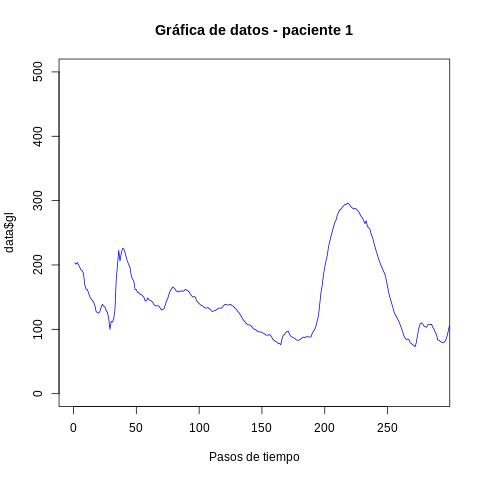

In [23]:
%%R
plot(data_pat_1$gl, type = "l", main = "Gráfica de datos - paciente 1", xlab = "Pasos de tiempo", ylab = "data$gl", col = "blue", xlim=c(0,288), ylim=c(0,500))

In [24]:
%%R
first_hypo_index <- which(data_pat_1$gl < 70)[1]
print(first_hypo_index)

[1] 314


In [25]:
%%R
obs_data_pat_1 = data_pat_1[1:310,]$gl

In [26]:
%%R
M <- 144
train <- list(x = obs_data_pat_1, N = length(obs_data_pat_1))
h.activity <- hsmmfit(train, model, mstep = mstep.gamma, maxit = 10000000, M = M, lock.transition = FALSE, lock.d = FALSE, graphical = FALSE)

In [27]:
%%R
predicted <- predict(h.activity,train)

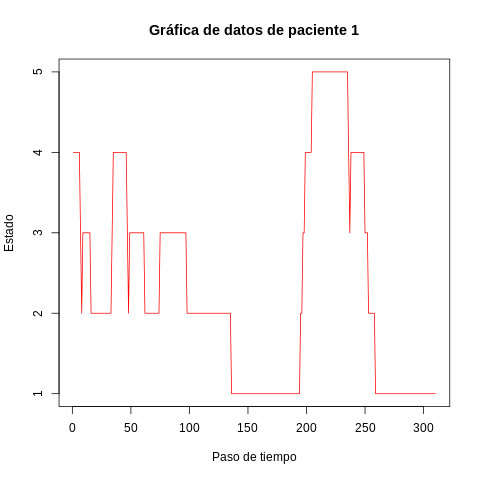

In [28]:
%%R
plot(predicted$s, type = "l", main = "Gráfica de datos de paciente 1",
     xlab = "Paso de tiempo", ylab = "Estado", col = "red")


In [29]:
%%R
result <- predict_hypoglycemia(h.activity, observed_CGM_list, predict_at = 60)

In [30]:
%%R
print(result)

$Prob_of_Hypo_30min
[1] 0 0 0 0 0 0

$Prob_of_Hypo_60min
[1] 0



In [ ]:
%%R
predict_window <- function(model, observed_CGM_list, window_size = 288, n_steps = 10, n_simulations = 10000, threshold = 70) {

  # Inicializar la matriz para guardar las predicciones (n_steps filas, 2 columnas)
  predictions_matrix <- matrix(0, nrow = n_steps, ncol = 2)
  colnames(predictions_matrix) <- c("Prob_Hypo_30min", "Prob_Hypo_60min")

  # Loop para mover la ventana de predicción
  for (i in 1:n_steps) {
    # Definir el rango de la ventana actual de observaciones
    current_start <- i
    current_end <- i + window_size - 1

    # Tomar la ventana actual de observaciones
    current_window <- observed_CGM_list[current_start:current_end]

    # Hacer la predicción para los próximos 6 (30 min) y 12 pasos (60 min)
    result <- predict_hypoglycemia(model, current_window, predict_at = 60, n_simulations = n_simulations, threshold = threshold)

    # Guardar las probabilidades en la matriz
    predictions_matrix[i, 1] <- result$prob_hypo_6_steps  # Probabilidad de hipoglucemia en 30 minutos (6 pasos)
    predictions_matrix[i, 2] <- result$prob_hypo_12_steps # Probabilidad de hipoglucemia en 60 minutos (12 pasos)

    # Verificar si hay suficientes datos para seguir moviendo la ventana
    if (current_end + 12 > length(observed_CGM_list)) break
  }

  return(predictions_matrix)
}


## Uso de Método de Montecarlo para cadenas de Markov para estimación de parámetros

En esta sección se realizaró una implementación de una función que estima parametros de un modelo oculto de semi-Markov con distribuciones de emisión y distribuciones de permanencia, ambas gamma. Se realizaron las funciones para n estados latentes posibles cuya matriz de transición es tridiagonal y su diagonal principal es 0 (Autotransiciones nulas). Los códigos se basaron en los algoritmos e implementaciones de "MCMC implementation for Bayesian hidden semi-Markov models with illustrative applications", nuestra segunda referencia principal.

Primero se implementó una función para simular datos, que fue igualmente la usada en la sección anterior.

In [ ]:
%%R
install.packages('MCMCpack')
library(MCMCpack)

(as ‘lib’ is unspecified)








In [132]:
%%R
sim.process <- function(L, id, num_states, noise_sd = 5, p.init, m.init, params_dist_emission, params_dist_sojourn) {
  ###############################################
  # Simula un proceso oculto de semi-Markov con #
  # transiciones entre estados según la matriz  #
  # de transición del modelo, y asigna valores  #
  # de glucosa y duraciones basados en          #
  # distribuciones específicas para cada estado.#
  ###############################################

  # Inicializamos las estructuras para guardar resultados
  chain <- c()    # Almacenará la secuencia de estados latentes
  time <- c()     # Almacenará los tiempos simulados
  gl <- c()       # Almacenará los valores simulados de glucosa

  # Definir la distribución inicial
    if (length(p.init) > 0) {
        p.init <- p.init
    } else {
        p.init <- rep(1/num_states, num_states)
    }

  # Matriz de transición (las transiciones permitidas son a estados adyacentes)
  if (length(m.init) > 0) {
    if (all(dim(m.init) == c(num_states, num_states)) && all(diag(m.init) == 0)) {
        # Asignar P a m.init si cumple las condiciones
        P <- m.init
    } else {
        stop("Error: m.init debe ser una matriz de tamaño num_states x num_states con ceros en la diagonal.")
    }
  } else {
    # Si m.init está vacío, crear la matriz aleatoria
    P <- matrix(0, num_states, num_states)
    for (i in 1:num_states) {
        if (i > 1) P[i, i-1] <- runif(1, 0, 1)  # Transición hacia atrás
        if (i < num_states) P[i, i+1] <- runif(1, 0, 1)  # Transición hacia adelante
    }
  }

  # Normalización de la matriz de transición
  P <- t(apply(P, 1, function(x) x / sum(x)))

  # Extraer los parámetros para las distribuciones de emisión desde params_dist_emission
  gamma_shape_gl <- sapply(1:num_states, function(i) params_dist_emission[i, 1])
  gamma_scale_gl <- sapply(1:num_states, function(i) params_dist_emission[i, 2])

  # Extraer los parámetros para las distribuciones de permanencia desde params_dist_sojourn
  gamma_shape_dur <- sapply(1:num_states, function(i) params_dist_sojourn[i, 1])
  gamma_scale_dur <- sapply(1:num_states, function(i) params_dist_sojourn[i, 2])

  current_state <- sample(1:num_states, 1, prob = p.init)

  start_time <- as.POSIXct(Sys.Date()) - sample(1:3650, 1) * 24 * 60 * 60
  start_time <- start_time + sample(0:(24*60*60 - 1), 1)

  while (length(chain) < L) {

    duration <- round(rgamma(1, shape = gamma_shape_dur[current_state], scale = gamma_scale_dur[current_state]))
    duration <- min(duration, L - length(chain))

    chain <- c(chain, rep(current_state, duration))

    gl_values <- rgamma(duration, shape = gamma_shape_gl[current_state], scale = gamma_scale_gl[current_state])
    gl <- c(gl, gl_values)

    # Generamos las marcas de tiempo en formato requerido
    if (length(time) == 0) {
      time <- seq(from = start_time, by = 5 * 60, length.out = duration)
    } else {
      last_time <- tail(time, 1)
      time <- c(time, seq(from = last_time + 5 * 60, by = 5 * 60, length.out = duration))
    }

    # Elegir el siguiente estado basado en las probabilidades de transición
    current_state <- sample(1:num_states, 1, prob = P[current_state,])
  }

  # Ajustamos el número de registros a exactamente L
  chain <- chain[1:L]
  gl <- gl[1:L]
  time <- time[1:L]

  # Agregar ruido gaussiano a los valores de glucosa
  gl_noise <- pmax(gl + rnorm(L, mean = 0, sd = noise_sd), 0)

  # Formateamos el tiempo al formato solicitado
  time <- format(time, "%Y-%m-%d %H:%M:%S")

  # Crear un dataframe con las columnas solicitadas
  result <- data.frame(
    id = rep(id, L),
    time = time,
    gl = gl,
    gl_noise = gl_noise,  # Columna con el ruido agregado
    state = chain  # Usamos la secuencia generada por el modelo
  )

  return(result)
}


Luego se implemento el algoritmo forward descrito en el documento del proyecto (Formulación a base de matrices). El algoritmo Forward es usado para calcular de forma eficiente la verosimilitud de los datos dado el modelo, este valor es el que tenemos que maximizar y para ello vamos a usar MCMC via metropolis-hastings. Tanto para el algoritmo forward como para el MCMC, se trabajó en escala logaritmica con el objetivo de no tener problemas de precisión por la pequeña escala numérica en la que se trabaja.

In [141]:
%%R
for.alg <- function (p.init, m.init, params_dist_emission, params_dist_sojourn, n_states, n, y) {
    ####################################################
    # Modelo con n estados latentes con distribuciones #
    # de emisión y de permanencia gamma.               #
    ####################################################

    # Se inicializan las probabilidades iniciales (p.init) en logaritmo
    p.init <- log(p.init)

   if (length(m.init) > 0) {
    if (all(dim(m.init) == c(n_states, n_states)) && all(diag(m.init) == 0)) {
        P <- m.init
    } else {
        stop("Error: m.init debe ser una matriz de tamaño num_states x num_states con ceros en la diagonal.")
    }
  } else {
    P <- matrix(0, n_states, n_states)
    for (i in 1:n_states) {
        if (i > 1) P[i, i-1] <- runif(1, 0, 1)  # Transición hacia atrás
        if (i < n_states) P[i, i+1] <- runif(1, 0, 1)  # Transición hacia adelante
    }
    diag(P) <- 0
  }
    P <- t(apply(P, 1, function(x) x / sum(x)))
    #print("===== Matriz de Transición =====")
    #print(P)
    # Z es una matriz de unos con la diagonal en 0, se utiliza para manejar las no-diagonales
    Z <- matrix(rep(1, n_states^2), n_states, n_states) - diag(n_states)

    ### Cálculo de las distribuciones de tiempos de permanencia (Gamma) ###
    log.P <- log(P)
    log.P[P == NA] <- -Inf

   # print("===== Log(Matriz de Transición) =====")
   # print(log.P)


    # Se calculan las densidades de la distribución de permanencia Gamma para cada estado
    log.h <- matrix(0, n-1, n_states)

    for (i in 1:n_states) {

      log.h[,i] <- dgamma(1:(n-1), shape=params_dist_sojourn[i, 1], scale=params_dist_sojourn[i, 2], log=T) -
                   log(1 - pgamma(0, shape=params_dist_sojourn[i, 1], scale=params_dist_sojourn[i, 2]))
    }

   # print("===== Log(Densidades de distribución de permanencia) (n-1 x n_states) =====")
   # print(log.h)

    # Se inicializa la primera columna de densidades de tiempo de permanencia
    log.H1 <- log.h[1,]

   # print("===== Log(Densidades de tiempo de permanencia para T = 1) (1 x n_states) =====")
   # print(log.H1)

    # Matriz de transición multiplicada por las densidades de permanencia (para 1 paso de tiempo)
    log.PH1 <- log.P + Z %*% diag(log.H1)
    #Hacer calculos

   # print("===== Log(Matriz de transición multiplicada por las densidades de permanencia) (1 x n_states) =====")
   # print(log.PH1)

    # Cálculo de las razones entre las densidades h(t) y h(t-1) para cada estado
    Ratios <- matrix(0, n-2, n_states)
    for (i in 1:n_states) {
      Ratios[,i] <- log.h[2:(n-1),i] - log.h[1:(n-2),i]
    }


   # print("===== razones entre las densidades h(t) y h(t-1) para cada estado =====")
   # print(Ratios)

    #####

    # Cálculo de las funciones de supervivencia para la distribución Gamma (permanencia en el estado)
    log.s <- matrix(0, n, n_states)
    for (i in 1:n_states) {
      log.s[,i] <- pgamma(0:(n-1), shape=params_dist_sojourn[i, 1], scale=params_dist_sojourn[i, 2], lower.tail=F, log.p=T) -
                   log(1 - pgamma(0, shape=params_dist_sojourn[i, 1], scale=params_dist_sojourn[i, 2]))
    }
    #####

    # Se inicializa la primera columna de supervivencia
    log.S1 <- log.s[1,]
    #####

    # Matriz de transición multiplicada por los valores de supervivencia para 1 paso de tiempo
    log.PS1 <- log.P + Z %*% diag(log.S1)
    #####

    # Cálculo de las razones entre las funciones de supervivencia y las densidades de permanencia
    S.Ratios <- matrix(0, n-1, n_states)
    for (i in 1:n_states) {
      S.Ratios[,i] <- log.s[2:n,i] - log.h[1:(n-1),i]
    }
    ####


    ### Cálculo de los valores del modelo condicional Gamma (emisión) ###
    log.F <- matrix(0, n, n_states)
    for (i in 1:n_states) {
      log.F[,i] <- dgamma(y, shape=params_dist_emission[i, 1], scale=params_dist_emission[i, 2], log=T)  # Densidad gamma para los valores observados
    }
    ###

    ### FUNCIÓN PARA CALCULAR EL LOG DE LA SUMA DE LOGS ###
    sumlog <- function(vec) {
      M <- max(vec)
      if(is.na(M)){ return(-Inf) }
      if (M == -Inf) { return(M) }
      result <- log(sum(exp(vec - M))) + M
      return(result)
    }

    ### INICIO DE LA RECURSIÓN ###
    alpha <- list()  # Lista para almacenar los vectores alpha
    Alpha <- list()  # Lista para almacenar las matrices alpha
    xi <- matrix(rep(0, n * n_states), n, n_states)  # Matriz para almacenar xi
    log.lik <- numeric(n)  # Vector para almacenar la verosimilitud en cada paso

    ### t=1 ###
    gamma <- p.init + log.H1 + log.F[1,]  # Cálculo de gamma para el primer paso
    log.lik[1] <- sumlog(gamma)  # Cálculo de la verosimilitud para t=1
    alpha[[1]] <- gamma - log.lik[1]  # Se ajusta alpha con el log-likelihood
    Alpha[[1]] <- matrix(rep(-Inf, n_states * n_states), n_states, n_states)
    diag(Alpha[[1]]) <- alpha[[1]]

    ### t=2 ###
    gamma <- gamma + Ratios[1,] + log.F[2,]  # Cálculo de gamma para t=2 (diagonales)
    A <- diag(alpha[[1]]) %*% Z + log.PH1 + Z %*% diag(log.F[2,])  # Cálculo de A (no-diagonales)
    xi[2,] <- 0

    for (j in 1:n_states) {
      xi[2,j] <- sumlog(A[-j,j])
    }

    xi[2,] <- xi[2,] + log.lik[1]  # Escalado para xi
    alpha[[2]] <- apply(matrix(c(gamma, xi[2,]), n_states, 2), 1, sumlog)
    log.lik[2] <- sumlog(alpha[[2]])  # Verosimilitud para t=2
    alpha[[2]] <- alpha[[2]] - log.lik[2]  # Escalado de alpha para t=2
    Alpha[[2]] <- A + matrix(log.lik[1], n_states, n_states)
    diag(Alpha[[2]]) <- gamma

    ### t=3,...,n-1 ###
    for (i in 3:(n-1)) {
      gamma <- gamma + Ratios[i-1,] + log.F[i,]  # Cálculo de gamma para t>=3 (diagonales)
      A <- diag(alpha[[i-1]]) %*% Z + log.PH1 + Z %*% diag(log.F[i,])  # Cálculo de A (no-diagonales)

      #xi[2:(i-1),] <- t(t(xi[2:(i-1),] + Ratios[(i-2):1,]) + log.F[i,])  # Cálculo de xi (diagonales)

      #Revisar de nuevooo

      for (k in 2:(i-1)) {
          for(j in 1:n_states){
              xi[k, j] <- xi[k, j] + Ratios[i-k, j] + log.F[i, j]
          }
      }

      for (j in 1:n_states) {
        xi[i,j] <- sumlog(A[-j, j])
      }
      xi[i,] <- xi[i,] + log.lik[i-1]  # Escalado para xi

      dummy <- apply(matrix(c(gamma, xi[2,]), n_states, 2), 1, sumlog)

      for (j in 3:(i-1)) {
        dummy <- apply(matrix(c(dummy, xi[j,]), n_states, 2), 1, sumlog)
      }
      alpha[[i]] <- apply(matrix(c(dummy, xi[i,]), n_states, 2), 1, sumlog)  # Actualización de alpha
      log.lik[i] <- sumlog(alpha[[i]])  # Verosimilitud para t=i
      alpha[[i]] <- alpha[[i]] - log.lik[i]  # Escalado de alpha
      Alpha[[i]] <- A + matrix(log.lik[i-1], n_states, n_states) - matrix(log.lik[i], n_states, n_states)
      diag(Alpha[[i]]) <- dummy - log.lik[i]
    }

    ### t=n -- Último paso, usando las funciones de supervivencia ###
    gamma <- gamma + S.Ratios[n-1,] + log.F[n,]  # Cálculo de gamma para el último paso
    #xi[2:(n-1),] <- t(t(xi[2:(n-1),] + S.Ratios[n-2:1,]) + log.F[n,])  # Cálculo de xi para el último paso
    A <- diag(alpha[[n-1]]) %*% Z + log.PS1 + Z %*% diag(log.F[n,])  # Cálculo de A (no-diagonales)

    for (k in 2:(n-1)) {
          for(j in 1:n_states){
              xi[k, j] <- xi[k, j] + Ratios[n-k, j] + log.F[n, j]
          }
    }



    for (j in 1:n_states) {
      xi[n,j] <- sumlog(A[-j, j])
    }

    xi[n,] <- xi[n,] + log.lik[n-1]  # Escalado para xi en el último paso

    dummy <- apply(matrix(c(gamma, xi[2,]), n_states, 2), 1, sumlog)
    for (j in 3:n) {
        dummy <- apply(matrix(c(dummy, xi[j,]), n_states, 2), 1, sumlog)
    }
    alpha[[n]] <- apply(matrix(c(dummy, xi[n,]), n_states, 2), 1, sumlog)  # Actualización de alpha
    log.lik[n] <- sumlog(alpha[[n]])  # Verosimilitud total
    Alpha[[n]] <- A + matrix(log.lik[n-1], n_states, n_states) - matrix(log.lik[n], n_states, n_states)
    diag(Alpha[[n]]) <- dummy - log.lik[n]


    return(log.lik[n])

}


Veamos ahora el algortimo de metropolis-hastings. Algunos detalles son que para las funciones de aceptación se usó la log-probabilidad a posteriori. Y las probabilidades a priori de los parametros fueron por una parte, distribuciones gamma para los parametros de las disrribuciones gamma, considerando que son parametros positivos y las distribuciones gamma solo toman parametros positivos. Por otro lado se usaron distribuciones dirichlet para las entradas del vector de probabilidad inicial e igualmente para las entradas no nulas de la matriz de transición.

Veamos a continuación la implementación de las funciones de densidad para gamma y dirichlet.

In [134]:
%%R
rDirichlet <-
function (n, alpha)
{
    l <- length(alpha)
    x <- matrix(nrow = n, ncol = l)
    for (i in 1:l) {
        x[, i] <- rGamma(n, alpha[i])
    }
    sm <- x %*% rep(1, l)
    return(x/as.vector(sm))
}

rGamma <-
function (N, SHAPE, RATE = 1, SCALE = 1/RATE)
{
    RGAMMA <- function(n, Shape, rate = 1, scale = 1/rate) {
        scale1 <- function(shape) {
            t <- 0.07 + 0.75 * sqrt(1 - shape)
            b <- 1 + (shape * exp(-t))/t
            YY <- 0
            while (YY == 0) {
                u1 <- runif(1)
                u2 <- runif(1)
                v <- b * u1
                if (v <= 1) {
                  x <- t * (v^(1/shape))
                  if (u2 <= (2 - x)/(2 + x)) {
                    YY <- x
                  }
                  else {
                    if (u2 <= exp(-x)) {
                      YY <- x
                    }
                  }
                }
                else {
                  x <- -log(t * (b - v)/shape)
                  y <- x/t
                  if (u2 * (shape + y * (1 - shape)) <= 1) {
                    YY <- x
                  }
                  else {
                    if (u2 <= y^(shape - 1)) {
                      YY <- x
                    }
                  }
                }
            }
            return(YY)
        }
        dummy <- 0
        for (i in 1:n) {
            dummy2 <- scale1(Shape)
            dummy[i] <- dummy2 * scale
        }
        return(dummy)
    }
    if (SHAPE <= 1) {
        return(RGAMMA(n = N, Shape = SHAPE, scale = SCALE))
    }
    else (return(rgamma(N, shape = SHAPE, scale = SCALE)))
}


Ahora, veamos la función que ajusta el modelo usando MCMC

In [142]:
%%R
fit.model <- function(n.sims, burn.in, inits = NULL, n_states, observed_data, M = 144) {
  library(MCMCpack)
  library(MASS)  # For mvrnorm

  Y <- observed_data
  n <- length(Y)



  ### FUNCTION TO EVALUATE THE LOG-POSTERIOR ###
  post <- function(log.lhood, emission_params, duration_params, p.init, trans_matrix) {
    if (any(emission_params <= 0) || any(duration_params <= 0) ) {return(-Inf)}

    log_prior <- 0

    # Log-prior for the transition matrix (only states 2 to n_states-1, ignoring states 1 and n_states)
    for (state in 2:(n_states - 1)) {
      trans_row <- trans_matrix[state, c(state - 1, state + 1)]
      # Ensure probabilities sum to 1 before computing log-prior
      trans_row <- trans_row / sum(trans_row)
      log_prior <- log_prior + log(ddirichlet(trans_row, c(1, 1)))  # Dirichlet prior for contiguous transitions
    }

    return(
      log.lhood +
        sum(dgamma(emission_params[, 1], 0.001, 0.001, log = TRUE)) +  # Shape for emissions
        sum(dgamma(emission_params[, 2], 0.001, 0.001, log = TRUE)) +  # Scale for emissions
        sum(dgamma(duration_params[, 1], 0.001, 0.001, log = TRUE)) +  # Shape for durations
        sum(dgamma(duration_params[, 2], 0.001, 0.001, log = TRUE)) +  # Scale for durations
        log(ddirichlet(p.init, rep(1, n_states)))
    )
  }

  ### LOGLIKELIHOOD VERIFY

  loglikelihood <- function(p.init, m.init, params_dist_emission, params_dist_sojourn, n_states, n, y) {
    # Verificar que todos los parámetros sean positivos
    #if (any(params_dist_emission<= 0)) {
    #    print("F")
    #    return(-Inf)
    #}

    #if (any(params_dist_sojourn<= 0)) {
    #    print("F")
    #    return(-Inf)
    #}

  # Si todos los parámetros son positivos, calcular la verosimilitud
  log_likelihood <- for.alg(p.init = p.init,
                            m.init = m.init,
                            params_dist_emission = params_dist_emission,
                            params_dist_sojourn = params_dist_sojourn,
                            n_states = n_states,
                            n = n,
                            y = y)

  return(log_likelihood)
}

  print("===== Iniciando MCMC =====")
  flush.console()
  ### INITIAL VALUES ###
  if (is.null(inits)) {
    emission_params <- matrix(c(runif(n_states, 1, 2), runif(n_states, 1, 2)), ncol = 2)
    duration_params <- matrix(c(runif(n_states, 1, 2), runif(n_states, 1, 2)), ncol = 2)

    p.initA <- rep(1 / n_states, n_states)
    trans_matrix <- diag(0, n_states)
    trans_matrix[row(trans_matrix) == col(trans_matrix) - 1] <- 0.5
    trans_matrix[row(trans_matrix) == col(trans_matrix) + 1] <- 0.5
    trans_matrix[1, 2] <- 1
    trans_matrix[n_states, n_states - 1] <- 1
  } else {
    emission_params <- inits$emission_params
    duration_params <- inits$duration_params
    p.initA <- inits$p.init
    trans_matrix <- inits$trans_matrix
  }

  print("===== Parámetros inicializados ======")
  print("Parámetros de emisión (shape y scale):")
  print(emission_params)
  print("Parámetros de duración (shape y scale):")
  print(duration_params)
  print("Distribución inicial (p.initA):")
  print(p.initA)
  print("Matriz de transición:")
  print(trans_matrix)
  flush.console()

  paramA <- c(emission_params[, 1],
              emission_params[, 2],
              duration_params[, 1],
              duration_params[, 2])

  ### Setup for MCMC Sampling ###
  n_params <- 7 * n_states - 4
  #sims.matrix <- matrix(nrow = n.sims, ncol = n_params + 2)  # parámetros + likelihood + posterior
  sims_list <- vector("list", n.sims)  # parámetros + likelihood + posterior

  log.likelihoodA <- loglikelihood(p.init = p.initA,
                             m.init = trans_matrix,
                             params_dist_emission = emission_params,
                             params_dist_sojourn = duration_params,
                             n_states = n_states,
                             n = n,
                             y = Y)

  print(paste("Initial Log-likelihood:", log.likelihoodA))
  flush.console()
  log.postA <- post(log.likelihoodA, emission_params, duration_params, p.initA, trans_matrix)

  accept1 <- accept2 <- accept3 <- 0

  U1 <- runif(n.sims)
  U2 <- runif(n.sims)
  U3 <- runif(n.sims)

  paramB <- paramA

  ### Variances of proposals for each parameter
  ss_shape_emission <- 1e-5  # Variance for shape of emission (n_states)
  ss_scale_emission <- 1e-5   # Variance for scale of emission (n_states)
  ss_shape_duration <- 5e-5    # Variance for shape of duration (n_states)
  ss_scale_duration <- 1e-5    # Variance for scale of duration (n_states)

  # Combine variances for each vector into a single vector
  VAR <- c(rep(ss_shape_emission, n_states),      # Shape for emissions
           rep(ss_scale_emission, n_states),     # Scale for emissions
           rep(ss_shape_duration, n_states),     # Shape for duration
           rep(ss_scale_duration, n_states))     # Scale for duration

  # Adjust the covariance matrix for the proposal distribution
  Sigma <- diag(VAR)

  # Generate proposal samples
  Q <- mvrnorm(n.sims, rep(0, length(VAR)), Sigma)  # Generate proposals
  Z_trans_matrix <- 200	### For adjusting acceptance rate of P
  Z_p.init <- 100	### For adjusting acceptance rate of p.init

  ### MCMC Sampling Process ###
  for (i in 1:n.sims) {
    if (i %% 100 == 0) {
      print("Verosimilitud:")
      print(log.likelihoodA)
      print(paste("Iteration:", i))
      flush.console()
    }

    paramB <- exp(log(paramA) + Q[i, ])  # Proposed values
    flush.console()
    ###################################
    # Update for emission params#
    ###################################

    emission_paramsB <- matrix(
      c(paramB[1:n_states], paramB[(n_states + 1):(2 * n_states)]),
      ncol = 2
    )

    log.likelihoodB <- loglikelihood(p.init = p.initA,
                               m.init = trans_matrix,
                               params_dist_emission = emission_paramsB,
                               params_dist_sojourn = duration_params,
                               n_states = n_states,
                               n = n,
                               y = Y)

    log.postB <- post(log.likelihoodB, emission_paramsB, duration_params, p.initA, trans_matrix)
    numer <- log.postB + sum(paramB[1:n_states]) + sum((n_states + 1):(2 * n_states))
    denom <- log.postA + sum(paramA[1:n_states]) + sum((n_states + 1):(2 * n_states))
    acceptance <- min(1, exp(numer - denom))
    #print("%%%%%%%%%%%%%%%%%%")
    #print("LOG.POSTB EMISSION")
    #print(log.postB)
    #print("%%%%%%%%%%%%%%%%%%")
    #print("%%%%%%%%%%%%%%%%%%")
    #print("PARAMS")
    #print(paramB[(n_states + 1):(2 * n_states)])
    #print("%%%%%%%%%%%%%%%%%%")
    if (log.postB > log.postA || U1[i] <= acceptance) {
      emission_params[, 1] <- emission_paramsB[, 1]
      paramA[1:n_states] <- paramB[1:n_states]
      paramA[(n_states + 1):(2 * n_states)] <- paramB[(n_states + 1):(2 * n_states)]
      accept1 <- accept1 + 1
      log.likelihoodA <- log.likelihoodB
      log.postA <- log.postB
    }

    #############################
    # Update for duration params #
    #############################

    duration_paramsB <- matrix(
      c(paramB[(2 * n_states + 1):(3 * n_states)], paramB[(3 * n_states + 1):(4 * n_states)]),
      ncol = 2
    )

    log.likelihoodB <- loglikelihood(p.init = p.initA,
                               m.init = trans_matrix,
                               params_dist_emission = emission_params,
                               params_dist_sojourn = duration_paramsB,
                               n_states = n_states,
                               n = n,
                               y = Y)

    log.postB <- post(log.likelihoodB, emission_params, duration_paramsB, p.initA, trans_matrix)
    numer <- log.postB + sum(paramB[(2 * n_states + 1):(3 * n_states)]) + sum(paramB[(3 * n_states + 1):(4 * n_states)])
    denom <- log.postA + sum(paramA[(2 * n_states + 1):(3 * n_states)]) + sum(paramA[(3 * n_states + 1):(4 * n_states)])

    acceptance <- min(1, exp(numer - denom))
    #print("%%%%%%%%%%%%%%%%%%")
    #print("LOG.POSTB SOJOURN")
    #print(log.postB)
    #print("%%%%%%%%%%%%%%%%%%")
    if (log.postB > log.postA || U2[i] <= acceptance) {
      duration_params[, 1] <- duration_paramsB[, 1]
      paramA[(2 * n_states + 1):(3 * n_states)] <- paramB[(2 * n_states + 1):(3 * n_states)]
      paramA[(3 * n_states + 1):(4 * n_states)] <- paramB[(3 * n_states + 1):(4 * n_states)]
      accept2 <- accept2 + 1
      log.likelihoodA <- log.likelihoodB
      log.postA <- log.postB
    }


    #####################
    # UPDATE FOR p.init and transition matrix using Dirichlet#
    #####################
    p.initB <- as.vector(rDirichlet(1, Z_p.init * p.initA))
    trans_matrixB <- trans_matrix

    for (state in 2:(n_states - 1)) {
      # Only update for intermediate states
      trans_probs <- rDirichlet(1, c(1, 1))  # Dirichlet for two transitions (to previous and next states)
      trans_matrixB[state, state - 1] <- trans_probs[1]
      trans_matrixB[state, state + 1] <- trans_probs[2]
      trans_matrixB[state, state] <- 0  # No self-transition
    }

    trans_matrixB[1, 2] <- 1
    trans_matrixB[n_states, n_states - 1] <- 1
    log.likelihoodB <- loglikelihood(p.init = p.initB,
                               m.init = trans_matrixB,
                               params_dist_emission = emission_params,
                               params_dist_sojourn = duration_params,
                               n_states = n_states,
                               n = n,
                               y = Y)

    log.postB <- post(log.likelihoodB, emission_params, duration_params, p.initB, trans_matrixB)
    numer <- log.postB
    denom <- log.postA

    numer <- log.postB  + log(ddirichlet(p.initA, Z_p.init * p.initB))
    denom <- log.postA  + log(ddirichlet(p.initB, Z_p.init * p.initA))


    for (state in 2:(n_states - 1)) {


        current_trans <- trans_matrix[state, c(state - 1, state + 1)]
        proposed_trans <- trans_matrixB[state, c(state - 1, state + 1)]


        log_prior_current_numer <- log(ddirichlet(current_trans, Z_trans_matrix * proposed_trans))

        log_prior_current_denom <- log(ddirichlet(proposed_trans, Z_trans_matrix * current_trans))


        numer <- numer + log_prior_current_numer
        denom <- denom + log_prior_current_denom
    }

    acceptance <- min(1, exp(numer - denom))

    #print("%%%%%%%%%%%%%%%%%%")
    #print("LOG.POSTB PROBS")
    #print(log.postB)
    #print("%%%%%%%%%%%%%%%%%%")
    if (!is.na(acceptance) && (log.postB > log.postA || U3[i] <= acceptance)) {
      p.initA <- p.initB
      trans_matrix <- trans_matrixB
      accept3 <- accept3 + 1
      log.likelihoodA <- log.likelihoodB
      log.postA <- log.postB
    }



    ##########################
    # Store the sampled values#
    ##########################

    sims_list[[i]] <- list(
    params_emission = emission_paramsB,
    params_sojourn = duration_params,
    trans_matrix = trans_matrix,
    p.init = p.initA,
    log.like = log.likelihoodB,
    log.pos = log.postB
  )

  }

  print("===== Muestreo Finalizado =====")
  print("Verosimilitud:")
  print(log.likelihoodA)
  return(list(sims_list = sims_list, acceptance_rates = c(accept1, accept2, accept3) / n.sims))
}


Ahora, hagamos una prueba de ajuste de parametros para los datos simulados:

In [ ]:
%%R
distribution_parameters_emission <- matrix(c(42.15187, 2.039293,
                                             110.10547, 1.107393,
                                             131.68450, 1.239174,
                                             151.21247, 1.419063,
                                             51.91903, 5.666516),
                                           nrow = 5, ncol = 2, byrow = TRUE)

distribution_parameters_sojourn <- matrix(c(0.7579934, 33.82615,
                                    0.9932942, 11.95013,
                                    1.1291341, 10.97301,
                                    1.2104759, 12.60661,
                                    1.1880755, 32.62419 ), nrow = 5, ncol = 2, byrow = TRUE)


p.init <- c(0.15, 0.225, 0.25, 0.225, 0.15)

m.init <- matrix(c(
  0, 1, 0, 0, 0,
  0.467, 0, 0.533, 0, 0,
  0, 0.546, 0, 0.454, 0,
  0, 0, 0.613, 0, 0.387,
  0, 0, 0, 1, 0
), nrow = 5, byrow = TRUE)


inits <- list(emission_params = distribution_parameters_emission,
              duration_params = distribution_parameters_sojourn,
              p.init = p.init,
              trans_matrix = trans_matrix)

results.hsmm <- fit.model(n.sims = 100, burn.in = 5, inits = inits, n_states = 5, observed_dat = data[1:10,]$gl)


[1] "===== Iniciando MCMC ====="
[1] "===== Parámetros inicializados ======"
[1] "Parámetros de emisión (shape y scale):"
          [,1]     [,2]
[1,]  42.15187 2.039293
[2,] 110.10547 1.107393
[3,] 131.68450 1.239174
[4,] 151.21247 1.419063
[5,]  51.91903 5.666516
[1] "Parámetros de duración (shape y scale):"
          [,1]     [,2]
[1,] 0.7579934 33.82615
[2,] 0.9932942 11.95013
[3,] 1.1291341 10.97301
[4,] 1.2104759 12.60661
[5,] 1.1880755 32.62419
[1] "Distribución inicial (p.initA):"
[1] 0.150 0.225 0.250 0.225 0.150
[1] "Matriz de transición:"
      [,1]  [,2]  [,3]  [,4]  [,5]
[1,] 0.000 1.000 0.000 0.000 0.000
[2,] 0.467 0.000 0.533 0.000 0.000
[3,] 0.000 0.546 0.000 0.454 0.000
[4,] 0.000 0.000 0.613 0.000 0.387
[5,] 0.000 0.000 0.000 1.000 0.000
[1] "Initial Log-likelihood: -41.1137838546447"


Exception ignored from cffi callback <function _processevents at 0x7f42b053e710>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/rpy2/rinterface_lib/callbacks.py", line 278, in _processevents
    processevents()
  File "/usr/local/lib/python3.10/dist-packages/rpy2/rinterface_lib/callbacks.py", line 262, in processevents
    def processevents() -> None:
KeyboardInterrupt: 
Exception ignored from cffi callback <function _processevents at 0x7f42b053e710>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/rpy2/rinterface_lib/callbacks.py", line 278, in _processevents
    processevents()
  File "/usr/local/lib/python3.10/dist-packages/rpy2/rinterface_lib/callbacks.py", line 262, in processevents
    def processevents() -> None:
KeyboardInterrupt: 
